<a href="https://colab.research.google.com/github/folaAj/jhu_nlp_class/blob/main/NLP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Installations

In [1]:

#@title Install hugging hugging face datasets
!pip install datasets
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

#@title Install higging face transformers library
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 12.7 MB/s 
     |████████████████████████████████| 7.6 MB 57.7 MB/s 


In [3]:

#@title install tensorflow text library
!pip install -q -U "tensorflow-text==2.8.*"

In [4]:

#@title Install tf models official
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 13.3 MB/s 
     |████████████████████████████████| 352 kB 52.6 MB/s 
     |████████████████████████████████| 1.1 MB 56.7 MB/s 
     |████████████████████████████████| 118 kB 69.1 MB/s 
     |████████████████████████████████| 1.3 MB 56.3 MB/s 
     |████████████████████████████████| 238 kB 60.0 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import  matplotlib.pyplot as plt
import unicodedata
import nltk
from tensorflow_addons.optimizers import AdamW
from official.nlp import optimization
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from datasets import load_dataset
from transformers import AutoTokenizer

tf.get_logger().setLevel('ERROR')

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Read dataset

I make use of the hugging face [rotten tomatoes dataset](https://huggingface.co/datasets/rotten_tomatoes).

In [6]:
dataset = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [9]:
from tokenizers import normalizers
from tokenizers.normalizers import NFKD, StripAccents 
normalizer = normalizers.Sequence([NFKD(), StripAccents()])

# Setup

Configure the distributed training strategy.

In [10]:
USE_TPU = False

In [11]:
def get_tpu_strategy():
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  return tpu_strategy

In [12]:
if USE_TPU:
  strategy = get_tpu_strategy()
else:
  strategy = tf.distribute.MirroredStrategy()

Set up the batch size and the utility functions

In [13]:
strategy.num_replicas_in_sync

1

In [14]:
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

In [15]:
def normalize(x):
  """Normalizes the sentiment text.

  Args:
    x: The sentiment text.
  
  Returns:
    The normalized text.
  """
  x['text'] = unicodedata.normalize('NFKD', x['text']).encode('ascii', 'ignore')
  return x

Retrieve dataset

In [16]:
train = dataset['train'].map(normalize).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(lambda x: (x['text'], x['label']))
val = dataset['validation'].map(normalize).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(lambda x: (x['text'], x['label']))
test = dataset['test'].map(normalize).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(lambda x: (x['text'], x['label']))

  0%|          | 0/8530 [00:00<?, ?ex/s]

  0%|          | 0/1066 [00:00<?, ?ex/s]

  0%|          | 0/1066 [00:00<?, ?ex/s]

In [17]:
def build_classifier_model(should_finetune):
  """Builds a BERT based sentiment analysis classifier.
  Args:
    should_finetune: whether to finetune BERT or not"""
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
  tfhub_handle_preprocess =  'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=should_finetune, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [18]:
def train_model(*, model, learning_rate, epochs, train_data, validation_data):
  with strategy.scope():
    metrics = tf.metrics.BinaryAccuracy()
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    steps_per_epoch = tf.data.experimental.cardinality(train_data).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')
    model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
  history = model.fit(x=train_data, validation_data=validation_data, epochs=epochs, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])
  return history

In [19]:
def plot_learning_curves(history):
  fig, ax = plt.subplots(2)
  # Plot accuracy
  ax[0].plot(history.history['binary_accuracy'])
  ax[0].plot(history.history['val_binary_accuracy'])
  ax[0].set_ylabel('accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].legend(['train', 'validation'], loc='upper left')
  # Plot loss
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_ylabel('loss')
  ax[1].set_xlabel('epoch')
  ax[1].legend(['train', 'validation'], loc='upper left')
  plt.show()

# Establish Baselines

### BERT baseline
For this baseline, I use a pretrained BERT model for feature extraction and try to use a neural network to predict if the sentiment is positive or negative.

In [20]:
with strategy.scope():
  baseline = build_classifier_model(should_finetune=False)

In [21]:
history = train_model(model = baseline, learning_rate=1e-05, epochs=35, train_data=train, validation_data=val)

Epoch 1/50
267/267 [==============================] - 46s 140ms/step - loss: 1.4848 - binary_accuracy: 0.5000 - val_loss: 1.4196 - val_binary_accuracy: 0.5000
Epoch 2/50
267/267 [==============================] - 40s 150ms/step - loss: 1.3443 - binary_accuracy: 0.5000 - val_loss: 1.2019 - val_binary_accuracy: 0.5000
Epoch 3/50
267/267 [==============================] - 31s 115ms/step - loss: 1.0746 - binary_accuracy: 0.4999 - val_loss: 0.9031 - val_binary_accuracy: 0.5000
Epoch 4/50
267/267 [==============================] - 35s 129ms/step - loss: 0.8146 - binary_accuracy: 0.5023 - val_loss: 0.7066 - val_binary_accuracy: 0.5084
Epoch 5/50
267/267 [==============================] - 35s 130ms/step - loss: 0.7176 - binary_accuracy: 0.5261 - val_loss: 0.6769 - val_binary_accuracy: 0.5291
Epoch 6/50
267/267 [==============================] - 39s 147ms/step - loss: 0.7039 - binary_accuracy: 0.5334 - val_loss: 0.6659 - val_binary_accuracy: 0.5460
Epoch 7/50
267/267 [==========================

KeyboardInterrupt: ignored

In [22]:
baseline.evaluate(test)

34/34 [==============================] - 7s 174ms/step - loss: 0.6000 - binary_accuracy: 0.6567


[0.6000387072563171, 0.6566604375839233]

In [23]:
plot_learning_curves(history)

NameError: ignored

A frozen BERT encoder with a classification head yields an accuraccy of 65.67% on the test set.

## Lexicon Baseline
For this baseline, I use SentiWordNet on each word of a review to count the positive and negative words. Each sentence is filtered down to the advjectives, adverbs and nouns in a sentence using POS tagging. I then run the words through SentiWordNet to retrieve the positive and negative scores, and if there are more positive than negative words in the review I mark the review positive, otherwise negative.



In [24]:
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [25]:
def penn_to_wn(tag):
    """Convert between the PennTreebank tags to simple Wordnet tags."""
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [26]:
from nltk.stem import WordNetLemmatizer

def count_pos_and_negative_words(after_tagging):
  lemmatizer = WordNetLemmatizer()
  pos_count = 0
  neg_count = 0
  for word, tag in after_tagging:
    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.ADJ, wn.ADV, wn.NOUN):
        continue
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        continue
    synsets = wn.synsets(lemma, pos=wn_tag)
    if not synsets:
        continue
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())
    if swn_synset.pos_score()>swn_synset.neg_score():
      pos_count+=1
    if swn_synset.neg_score() > swn_synset.pos_score():
      neg_count+=1
  return pos_count, neg_count

In [27]:
accuracies = []
for batch in test:
  sentiments = []
  for review in batch[0]:
    token = nltk.word_tokenize(review.numpy().decode())
    after_tagging = nltk.pos_tag(token)
    pos_count, neg_count = count_pos_and_negative_words(after_tagging)
    if pos_count>neg_count:
      sentiments.append(1)
    else:
      sentiments.append(0)
  accuracy = tf.math.count_nonzero(tf.cast(sentiments == batch[1], tf.int32))/len(sentiments)
  accuracies.append(accuracy)

In [28]:
import numpy as np
np.average(accuracies)

0.5810661764705882

By simply counting the number of positive and negative adjective, nouns and adverbs (according to SentiWordNet) in a sentence, we are able to achieve 57.9% accuracy on the test set.

# Model

## Finetune  a BERT Model For Sentiment Analysis on Rotten Tomaotoes Dataset.

In [29]:
with strategy.scope():
  bert_finetuned_model = build_classifier_model(should_finetune=True)

In [30]:
finetuned_history = train_model(model = bert_finetuned_model, learning_rate=1e-05, epochs=20, train_data=train, validation_data=val)

Epoch 1/20
267/267 [==============================] - 73s 241ms/step - loss: 0.6543 - binary_accuracy: 0.5919 - val_loss: 0.5111 - val_binary_accuracy: 0.7308
Epoch 2/20
267/267 [==============================] - 65s 244ms/step - loss: 0.4934 - binary_accuracy: 0.7569 - val_loss: 0.4522 - val_binary_accuracy: 0.7899
Epoch 3/20
267/267 [==============================] - 62s 232ms/step - loss: 0.3854 - binary_accuracy: 0.8222 - val_loss: 0.4391 - val_binary_accuracy: 0.8049
Epoch 4/20
267/267 [==============================] - 63s 236ms/step - loss: 0.2800 - binary_accuracy: 0.8819 - val_loss: 0.4942 - val_binary_accuracy: 0.8002
Epoch 5/20
267/267 [==============================] - 65s 243ms/step - loss: 0.2004 - binary_accuracy: 0.9177 - val_loss: 0.6320 - val_binary_accuracy: 0.7964


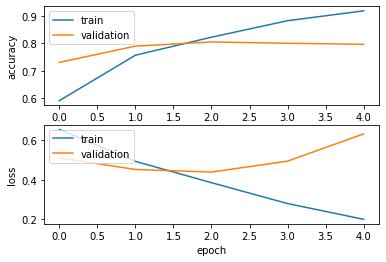

In [31]:
plot_learning_curves(finetuned_history)

In [32]:
bert_finetuned_model.evaluate(test)

34/34 [==============================] - 4s 100ms/step - loss: 0.6043 - binary_accuracy: 0.8114


[0.6042855978012085, 0.8114446401596069]

The model yields an accuract of 81.1% on the test set

## Add positive and negtive word count features for sentiment prediction.



In [33]:
def add_count_feature(x):
  token = nltk.word_tokenize(x['text'])
  after_tagging = nltk.pos_tag(token)
  pos_count, neg_count = count_pos_and_negative_words(after_tagging)
  x['pos_count'] = pos_count
  x['neg_count'] = neg_count
  return x

tensor_fn = lambda x: {'text':x['text'],'pos_count': x['pos_count'], 'neg_count': x['neg_count'], 'label':x['label']}

train_with_counts = dataset['train'].map(normalize).map(add_count_feature).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(tensor_fn)
val_with_counts = dataset['validation'].map(normalize).map(add_count_feature).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(tensor_fn)
test_with_counts = dataset['test'].map(normalize).map(add_count_feature).to_tf_dataset(batch_size=BATCH_SIZE, shuffle=True).map(tensor_fn)

  0%|          | 0/8530 [00:00<?, ?ex/s]

  0%|          | 0/1066 [00:00<?, ?ex/s]

  0%|          | 0/1066 [00:00<?, ?ex/s]

In [34]:
def build_classifier_model_with_counts(should_finetune):
  """Builds a BERT based sentiment analysis classifier.
  Args:
    should_finetune: whether to finetune BERT or not"""
  tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
  tfhub_handle_preprocess =  'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  pos_count_input = tf.keras.layers.Input(shape=(), dtype=tf.int32, name='pos_count')
  neg_count_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='neg_count')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=should_finetune, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.concatenate([net, pos_count_input, neg_count_input])
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [35]:
with strategy.scope():
  model = build_classifier_model(should_finetune=True)

In [36]:
finetuned_with_counts_history = train_model(model = model, learning_rate=1e-05, epochs=20, train_data=train, validation_data=val)

Epoch 1/20
267/267 [==============================] - 72s 244ms/step - loss: 0.6559 - binary_accuracy: 0.6067 - val_loss: 0.4958 - val_binary_accuracy: 0.7561
Epoch 2/20
267/267 [==============================] - 63s 237ms/step - loss: 0.4942 - binary_accuracy: 0.7593 - val_loss: 0.5034 - val_binary_accuracy: 0.7899
Epoch 3/20
267/267 [==============================] - 62s 232ms/step - loss: 0.3882 - binary_accuracy: 0.8283 - val_loss: 0.4208 - val_binary_accuracy: 0.8161
Epoch 4/20
267/267 [==============================] - 63s 236ms/step - loss: 0.2841 - binary_accuracy: 0.8808 - val_loss: 0.4671 - val_binary_accuracy: 0.8096
Epoch 5/20
267/267 [==============================] - 63s 236ms/step - loss: 0.1937 - binary_accuracy: 0.9191 - val_loss: 0.5319 - val_binary_accuracy: 0.8124


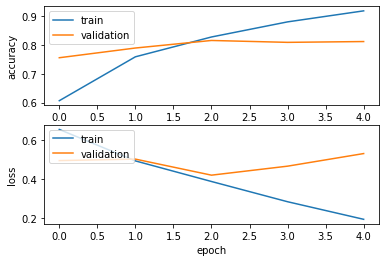

In [37]:
plot_learning_curves(finetuned_with_counts_history)

In [38]:
model.evaluate(test)

34/34 [==============================] - 4s 114ms/step - loss: 0.5386 - binary_accuracy: 0.8143


[0.5386146903038025, 0.8142589330673218]

This model achieves an 81.4% accuracy on the test set.
We see that adding the positive and negative word count improves the accuracy by .3%.